# Building and Training a Simple RNN Model using PyTorch for Predicting Sine Wave Patterns

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

### Generate data

Let's create a simple dataset to train our network on. We'll use a sine wave as the input sequence and try to predict the next value in the sequence. We'll create a dataset of 1000 sequences with 10 time steps each.

In [2]:
timesteps = 10
data_size = 1000

input_data = np.zeros((data_size, timesteps, 1))
output_data = np.zeros((data_size, 1))

for i in range(data_size):
    rand_offset = np.random.random() * 2 * np.pi
    input_data[i, :, 0] = np.sin(np.linspace(0.0 + rand_offset, 3 * np.pi + rand_offset, num=timesteps))
    output_data[i, 0] = np.sin(3 * np.pi + rand_offset)

**Explanation**

First, we define two variables: `timesteps` and `data_size`. `timesteps` determines the length of each input sequence, and `data_size` determines the number of samples we want to generate.

Next, we create two NumPy arrays to hold our input and output data. `input_data` is a 3-dimensional array with shape `(data_size, timesteps, 1)`. This means that we have `data_size` samples, each with `timesteps` time steps, and 1 feature at each time step. `output_data` is a 2-dimensional array with shape `(data_size, 1)`, which means that we have `data_size` output samples, each with 1 feature.

Then, we loop through each sample in our dataset using a for loop. For each sample, we generate a random offset between 0 and 2π using `np.random.random() * 2 * np.pi`. This offset is used to shift the sine wave we generate for the input sequence.

We generate the input sequence by calling `np.linspace` to create a sequence of timesteps values evenly spaced between 0 and 3π (inclusive), and adding the random offset to each value. We then pass this sequence through the `np.sin` function to generate the sine wave.

We generate the output value by computing the sine of 3π plus the random offset. This is the next value in the sine wave after the input sequence ends.

Finally, we assign the input sequence and output value to the corresponding rows in `input_data` and `output_data`, respectively.

Overall, this code generates a dataset of `data_size` samples, where each sample consists of an input sequence of `timesteps` time steps and an output value that is the next value in the sine wave after the input sequence ends. The offset applied to each sample's sine wave introduces variability to the dataset, making it more challenging for our model to learn the underlying pattern in the data.

Let's visualize this data.

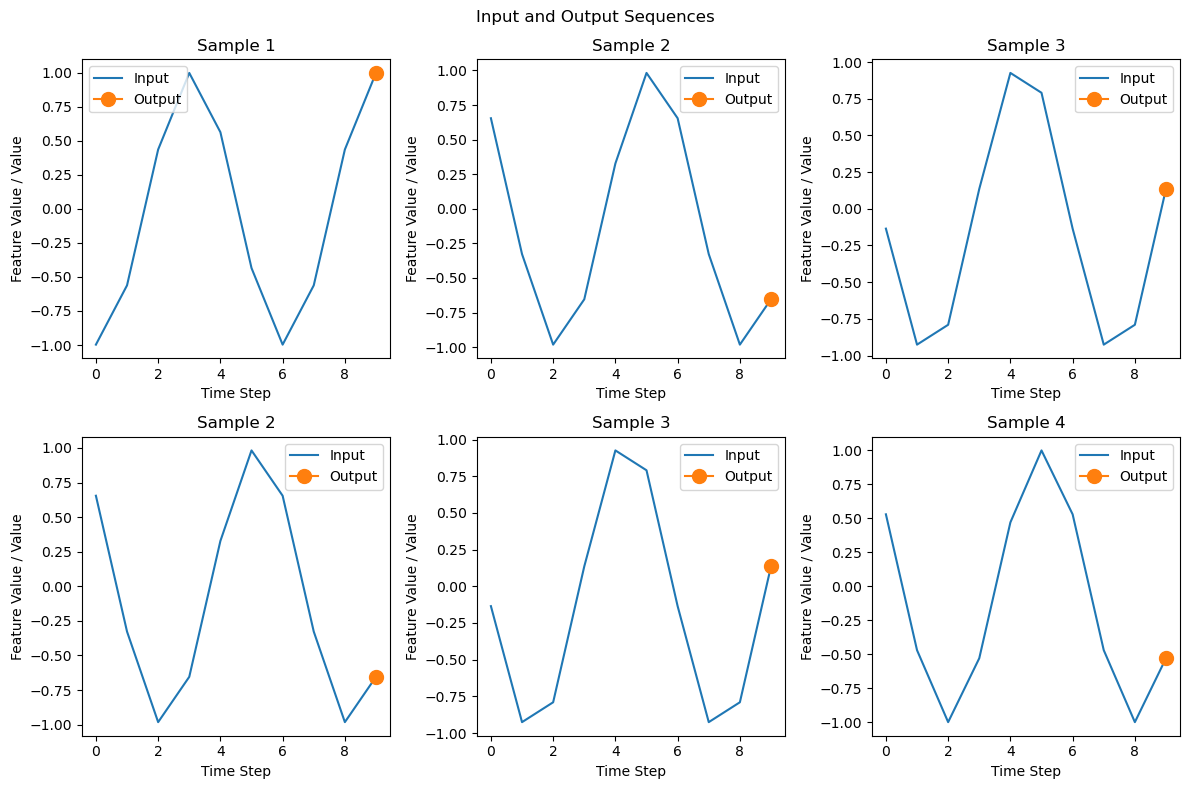

In [3]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))

for i in range(2):
    for j in range(3):
        # plot input sequence
        axs[i,j].plot(input_data[i+j,:,0], label='Input')

        # plot output value with big marker
        axs[i,j].plot(range(timesteps-1, timesteps), output_data[i+j], marker='o', markersize=10, label='Output')

        # set plot title, axis labels, and legend
        axs[i,j].set_title(f'Sample {i+j+1}')
        axs[i,j].set_xlabel('Time Step')
        axs[i,j].set_ylabel('Feature Value / Value')
        axs[i,j].legend()

plt.suptitle('Input and Output Sequences')
plt.tight_layout()
plt.show()

Now, let's split the dataset into training and testing sets:

In [4]:
train_size = int(data_size * 0.8)

X_train = input_data[:train_size, :, :]
y_train = output_data[:train_size, :]

X_test = input_data[train_size:, :, :]
y_test = output_data[train_size:, :]

### Define the RNN model

We'll use a simple RNN with a single hidden layer:

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Create a new RNN layer with 1 input feature, 32 hidden units, and 1 layer
        self.rnn = nn.RNN(input_size=1, hidden_size=32, num_layers=1, batch_first=True)

        # Create a new fully connected layer with 32 input features and 1 output feature
        self.fc = nn.Linear(32, 1)

    def forward(self, x):
        """
        Passes the input tensor through the RNN and the fully connected layer.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, sequence_length, input_size)

        Returns:
            torch.Tensor: Output tensor of shape (batch_size, 1)
        """
        # Pass the input tensor through the RNN layer, which returns a new tensor with
        # shape (batch_size, sequence_length, hidden_size)
        rnn_out, _ = self.rnn(x)

        # Pass the last output from the RNN layer through the fully connected layer,
        # which returns a new tensor with shape (batch_size, 1)
        fc_out = self.fc(rnn_out[:, -1, :])

        # Return the output tensor
        return fc_out

**Explanation**:

The Net class inherits from the PyTorch nn.Module class, which allows us to define our neural network as a collection of layers that can be trained together.

In the `__init__` method, we define our RNN layer and fully connected layer:

* `self.rnn:` A new `nn.RNN` layer with 1 input feature (`input_size=1`), 32 hidden units (`hidden_size=32`), and 1 layer (`num_layers=1`). We set` batch_first=True` so that the input tensor has shape `(batch_size, sequence_length, input_size)`.
* `self.fc`: A new `nn.Linear` layer with 32 input features (`in_features=32`) and 1 output feature (`out_features=1`).

In the forward method, we define how the input tensor is passed through our network:

* We pass the input tensor `x` through the RNN layer using `self.rnn(x)`. This returns a new tensor with shape `(batch_size, sequence_length, hidden_size)`.
* We take the last output from the RNN layer using `rnn_out[:, -1, :]`. This returns a tensor with shape `(batch_size, hidden_size)`.
* We pass this last output through the fully connected layer using `self.fc(rnn_out[:, -1, :])`. This returns a tensor with shape `(batch_size, 1)`.
* We return the output tensor.

Note that the `_` in `rnn_out, _ = self.rnn(x)` indicates that we are only interested in the first output of `self.rnn(x)`, which is the output tensor, and not the second output, which is the final hidden state of the RNN layer. Since we are not using this hidden state, we can ignore it by assigning it to `_`.

In [6]:
net = Net()

We'll use mean squared error loss and the Adam optimizer:

In [7]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.01)

**Explanation**

The MSE loss function is a commonly used loss function for regression problems. It measures the average of the squared differences between the predicted output and the true output. In our case, we want our RNN to predict the sine wave value at the last time step given the input sequence, which is a regression problem. Therefore, using the MSE loss function is appropriate.

The Adam optimizer is a popular stochastic gradient descent optimizer that is known for its efficiency and robustness. It adapts the learning rate for each parameter based on the first and second moments of the gradients. In other words, it adjusts the learning rate for each weight in the network based on how much and how quickly the weight is changing. This helps the optimizer converge faster and more reliably than other stochastic gradient descent optimizers. Therefore, using the Adam optimizer is a good choice for training our RNN.

In summary, we used the MSE loss function because we have a regression problem, and we used the Adam optimizer because it is efficient and robust.

Now, we'll define our training loop. We'll train the network for 70 epochs and calculate the training and validation loss after each epoch:

In [8]:
train_losses = []
val_losses = []

for epoch in range(70):
    net.train()
    optimizer.zero_grad()

    outputs = net(torch.Tensor(X_train))
    loss = criterion(outputs, torch.Tensor(y_train))

    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())

    net.eval()
    with torch.no_grad():
        outputs = net(torch.Tensor(X_test))
        val_loss = criterion(outputs, torch.Tensor(y_test))
        val_losses.append(val_loss.item())

    print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'
          .format(epoch+1, 70, loss.item(), val_loss.item()))

Epoch [1/70], Train Loss: 0.4836, Val Loss: 0.3494
Epoch [2/70], Train Loss: 0.3717, Val Loss: 0.2673
Epoch [3/70], Train Loss: 0.2769, Val Loss: 0.1612
Epoch [4/70], Train Loss: 0.1669, Val Loss: 0.0465
Epoch [5/70], Train Loss: 0.0476, Val Loss: 0.0145
Epoch [6/70], Train Loss: 0.0160, Val Loss: 0.1077
Epoch [7/70], Train Loss: 0.1057, Val Loss: 0.0593
Epoch [8/70], Train Loss: 0.0560, Val Loss: 0.0140
Epoch [9/70], Train Loss: 0.0129, Val Loss: 0.0145
Epoch [10/70], Train Loss: 0.0177, Val Loss: 0.0249
Epoch [11/70], Train Loss: 0.0291, Val Loss: 0.0335
Epoch [12/70], Train Loss: 0.0359, Val Loss: 0.0373
Epoch [13/70], Train Loss: 0.0373, Val Loss: 0.0320
Epoch [14/70], Train Loss: 0.0308, Val Loss: 0.0188
Epoch [15/70], Train Loss: 0.0176, Val Loss: 0.0056
Epoch [16/70], Train Loss: 0.0050, Val Loss: 0.0019
Epoch [17/70], Train Loss: 0.0020, Val Loss: 0.0080
Epoch [18/70], Train Loss: 0.0085, Val Loss: 0.0143
Epoch [19/70], Train Loss: 0.0145, Val Loss: 0.0151
Epoch [20/70], Train 

**Explanation**

* `train_losses = []` and `val_losses = []`: These create two empty lists to store the training and validation losses for each epoch.
* `for epoch in range(70)`: This starts a loop that will run for 70 epochs, during which the network will be trained and evaluated.
* `net.train()` sets the network in training mode.
* `optimizer.zero_grad()` zeroes out the gradients of the network's parameters, so that they don't accumulate from one iteration to the next.
* `outputs = net(torch.Tensor(X_train))` passes the training input data `X_train` through the network to get the predicted output `outputs`.
* `loss = criterion(outputs, torch.Tensor(y_train))` calculates the training loss between the predicted output `outputs` and the true output `y_train` using the mean squared error (MSE) loss function.
* `loss.backward()` computes the gradients of the loss with respect to the network's parameters.
* `optimizer.step()` updates the network's parameters based on the computed gradients and the optimizer's update rule (in this case, Adam).
* `train_losses.append(loss.item())` appends the training loss for the current epoch to the `train_losses` list.
* `net.eval()` sets the network in evaluation mode.
* `with torch.no_grad()`: temporarily disables gradient computation to save memory and speed up the evaluation process.
* `outputs = net(torch.Tensor(X_test))` passes the validation input data `X_test` through the network to get the predicted output `outputs`.
* `val_loss = criterion(outputs, torch.Tensor(y_test))` calculates the validation loss between the predicted output `outputs` and the true output `y_test` using the mean squared error (MSE) loss function.
* `val_losses.append(val_loss.item())` appends the validation loss for the current epoch to the `val_losses` list.
* `print('Epoch [{}/{}], Train Loss: {:.4f}, Val Loss: {:.4f}'.format(epoch+1, 100, loss.item(), val_loss.item()))` prints the current epoch number, the training loss, and the validation loss.

The training loop trains the RNN on the training data for 70 epochs using the Adam optimizer and the mean squared error loss function. The loop also computes and records the training and validation losses for each epoch, so that the performance of the model can be analyzed over time.

Finally, let's plot the training and validation loss over epochs:

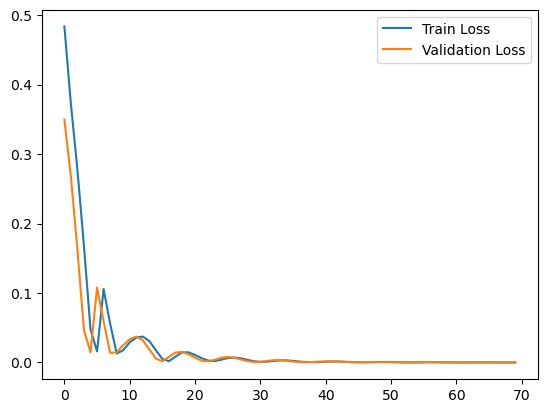

In [9]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.legend()
plt.show()

And that's it! We've successfully trained a simple RNN to predict the next value in a sine wave sequence.